In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting.mcmc import plot_mcmc
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
import pymc
%matplotlib inline

In [25]:
 ### Modeled after AstroML book figure 10.25
## burst model replaced by gaussian profile

#----------------------------------------------------------------------
# Set up toy dataset
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

#np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

t = 100 * np.random.random(N)
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)
#----------------------------------------------------------------------

 [-----------------100%-----------------] 25000 of 25000 complete in 4.8 sec
[  9.96953814   3.67054808   3.0921965   39.61845202]


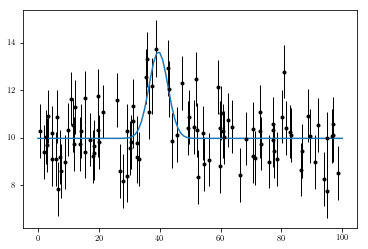

In [31]:
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

#------------------------------------------------------------
plt.plot(figsize=[9,9])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, *fit_vals)
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k')
plt.plot(t_fit,y_fit)
print()
print(np.array(fit_vals))

plt.show()